# Importing libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from google.colab import files
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import gc
import lightgbm as lgb
import json
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
import datetime
import pickle
import random

In [ ]:
# Connecting to google drive
#Taken help from https://stackoverflow.com/questions/69822304/google-colab-google-drive-can%c2%b4t-be-mounted-anymore-browser-popup-google-dri
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

# Downloading Data

In [ ]:
def download_data():
  '''This function downloads the data into google colab and set up everythiing to process further with data.
  Only things is you need to upload kaggle.json file which contains the user credential to letting api download data from kaggle
  '''
  # Requirement for downloading data directly to google colab
  files.upload()
  ! pip install kaggle
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  # Downloading data to google colab
  !kaggle competitions download -c elo-merchant-category-recommendation
  # unzipping the required files
  !unzip new_merchant_transactions.csv.zip
  !unzip sample_submission.csv.zip
  !unzip merchants.csv.zip
  !unzip test.csv.zip
  !unzip train.csv.zip
  !unzip historical_transactions.csv.zip
  # Deleting useless old zip files
  !rm new_merchant_transactions.csv.zip
  !rm sample_submission.csv.zip
  !rm merchants.csv.zip
  !rm test.csv.zip
  !rm train.csv.zip
  !rm historical_transactions.csv.zip
  !mv new_merchant_transactions.csv /content/drive/MyDrive/appliedai/assignment/case_study_1/real_case_study_part
  !mv sample_submission.csv /content/drive/MyDrive/appliedai/assignment/case_study_1/real_case_study_part
  !mv merchants.csv /content/drive/MyDrive/appliedai/assignment/case_study_1/real_case_study_part
  !mv test.csv /content/drive/MyDrive/appliedai/assignment/case_study_1/real_case_study_part
  !mv train.csv /content/drive/MyDrive/appliedai/assignment/case_study_1/real_case_study_part
  !mv historical_transactions.csv /content/drive/MyDrive/appliedai/assignment/case_study_1/real_case_study_part
  os.chdir('/content/drive/MyDrive/appliedai/assignment/case_study_1/real_case_study_part')

In [ ]:
download_data()

Saving kaggle.json to kaggle.json
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 102MB/s]
  0% 0.00/1.13M [00:00<?, ?B/s]
100% 1.13M/1.13M [00:00<00:00, 157MB/s]
 77% 38.0M/49.4M [00:00<00:00, 60.2MB/s]
100% 49.4M/49.4M [00:00<00:00, 142MB/s] 
 95% 523M/548M [00:02<00:00, 220MB/s]
100% 548M/548M [00:02<00:00, 203MB/s]
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 119MB/s]
  0% 0.00/12.7M [00:00<?, ?B/s]
100% 12.7M/12.7M [00:00<00:00, 117MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 18.2MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 17.5MB/s]
Archive:  new_merchant_transactions.csv.zip
  inflating: new_merchant_transactions.csv  
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  merchants.csv.zip
  inflating: merchants.csv           
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  historical_tran

# Train and test data processing

Here time series data is provided in the train and test dataset and it can not be directly used thats why there are many features derived from the timeseries data

The reason for creating this festival features is that normally people purchase behaviour changes around festival therefore to see it influence on loyalty we added these features

In [ ]:
def preprocessing_and_feature_engineering_train_and_test_data():
  '''This function performs preprocessing and then does adds new features(feature engineering) 
  on train and test data by taking train and test data as input'''
  train = pd.read_csv('train.csv',parse_dates=['first_active_month'])
  test = pd.read_csv('test.csv',parse_dates=['first_active_month'])

  train['days'] = (dt.date(2022,1,18)-pd.to_datetime(train['first_active_month']).dt.date).dt.days
  train['quarter'] = pd.to_datetime(train['first_active_month']).dt.quarter
  test['days'] = (dt.date(2022,1,18)-pd.to_datetime(test['first_active_month']).dt.date).dt.days
  test['quarter'] = pd.to_datetime(test['first_active_month']).dt.quarter
  train['date_difference_from_today']=abs(dt.date.today() - pd.to_datetime(train['first_active_month']).dt.date)
  train['date_difference_from_today'] = train['date_difference_from_today'].map(lambda x: np.nan if pd.isnull(x) else x.days)
  test['date_difference_from_today']=abs(dt.date.today() - pd.to_datetime(test['first_active_month']).dt.date)
  test['date_difference_from_today'] = test['date_difference_from_today'].map(lambda x: np.nan if pd.isnull(x) else x.days)
  train['day_of_week'] = pd.to_datetime(train['first_active_month']).dt.weekday
  train['year'] = pd.to_datetime(train['first_active_month']).dt.year
  test['day_of_week'] = pd.to_datetime(test['first_active_month']).dt.weekday
  test['year'] = pd.to_datetime(test['first_active_month']).dt.year
  train['month_of_year_first_active_month'] = pd.to_datetime(train['first_active_month']).dt.month
  test['month_of_year_first_active_month'] = pd.to_datetime(test['first_active_month']).dt.month
  train['month_start'] = pd.to_datetime(train['first_active_month']).dt.is_month_start
  test['month_start'] = pd.to_datetime(test['first_active_month']).dt.is_month_start
  train['day_of_year'] = pd.to_datetime(train['first_active_month']).dt.dayofyear
  test['day_of_year'] = pd.to_datetime(test['first_active_month']).dt.dayofyear

    # Inspired from https://www.kaggle.com/roydatascience/elo-merchant-recommendation-fathers-day-specials
  #if purchase made in 60 days it is considered as influence
  train['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - pd.to_datetime(train['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  train['Children_day_2017'] = (pd.to_datetime('2017-10-12') - pd.to_datetime(train['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  train['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - pd.to_datetime(train['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  train['Valentine_day_2017'] = (pd.to_datetime('2017-06-12') - pd.to_datetime(train['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  train['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13') - pd.to_datetime(train['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  train['fathers_day_2017'] = (pd.to_datetime('2017-08-13') - pd.to_datetime(train['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

  test['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - pd.to_datetime(test['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  test['Children_day_2017'] = (pd.to_datetime('2017-10-12') - pd.to_datetime(test['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  test['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - pd.to_datetime(test['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  test['Valentine_day_2017'] = (pd.to_datetime('2017-06-12') - pd.to_datetime(test['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  test['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13') - pd.to_datetime(test['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  test['fathers_day_2017'] = (pd.to_datetime('2017-08-13') - pd.to_datetime(test['first_active_month'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

  train['outliers'] = 0
  train.loc[train['target'] < -30, 'outliers'] = 1

  # Inspired from 
  for i in ['feature_1','feature_2','feature_3']:
    train['days_'+i] = train['days']*train[i]
    train['days_'+i + '_ratio'] = train[i]/train['days']

  for i in ['feature_1','feature_2','feature_3']:
    test['days_'+i] = test['days']*test[i]
    test['days_'+i + '_ratio'] = test[i]/test['days']

  gc.collect()
  return train,test





# Historical transaction data processing

In this part we going to do preprocessing for historical transaction and adding some new features

In [ ]:
# Inspired from https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82055#:~:text=def%20word2vec_feature(prefix,shape))%0A%20%20%20%20return%20df_w2v
def word2vec_feature(prefix, df, groupby, target,size):
    '''Converts the categorcal columns to vector form through word_2_vec technique
    '''
    df_bag = pd.DataFrame(df[[groupby, target]])
    df_bag[target] = df_bag[target].astype(str)
    df_bag[target].fillna('NAN', inplace=True)
    df_bag = df_bag.groupby(groupby, as_index=False)[target].agg({'list':(lambda x: list(x))}).reset_index()
    doc_list = list(df_bag['list'].values)
    w2v = Word2Vec(doc_list, size=size, window=3, min_count=1, workers=32)
    vocab_keys = list(w2v.wv.vocab.keys())
    w2v_array = []
    for v in vocab_keys :
        w2v_array.append(list(w2v.wv[v]))
    df_w2v = pd.DataFrame()
    df_w2v['vocab_keys'] = vocab_keys    
    df_w2v = pd.concat([df_w2v, pd.DataFrame(w2v_array)], axis=1)
    df_w2v.columns = [target] + ['w2v_%s_%s_%d'%(prefix,target,x) for x in range(size)]
    try:
      del w2v_array,vocab_keys,doc_list,df_bag,prefix, df, groupby, target,size
    except:
      pass
    return df_w2v



In [ ]:
def categorical_column_of_historical_transaction_with_word2vec(historical_transaction):
  '''This function add word 2 vec vectors for categorical columns for historical transactions table
  '''
  historical_transaction['card_id_2'] = historical_transaction['card_id']
  historical_transaction['purchase_date_only'] = pd.to_datetime(historical_transaction['purchase_date']).dt.date
  card_id_word_2_vec = word2vec_feature('hist_data',historical_transaction,'card_id','card_id_2',5)
  merchant_category_id_word_2_vec = word2vec_feature('hist_data',historical_transaction,'card_id','merchant_category_id',3)
  subsector_id_word_2_vec = word2vec_feature('hist_data',historical_transaction,'card_id','subsector_id',3)
  month_lag_word_2_vec = word2vec_feature('hist_data',historical_transaction,'card_id','month_lag',3)
  purchase_date_word_2_vec = word2vec_feature('hist_data',historical_transaction,'card_id','purchase_date_only',5)
  card_id_word_2_vec.rename(columns = {'card_id_2':'card_id'}, inplace = True)
  historical_transaction = pd.merge(historical_transaction,card_id_word_2_vec,on='card_id',how='left')
  try:
    del card_id_word_2_vec
  except:
    pass
  merchant_category_id_word_2_vec['merchant_category_id'] = merchant_category_id_word_2_vec['merchant_category_id'].astype('int')
  historical_transaction = pd.merge(historical_transaction,merchant_category_id_word_2_vec,on='merchant_category_id',how='left')
  try:
    del merchant_category_id_word_2_vec
  except:
    pass
  subsector_id_word_2_vec['subsector_id'] = subsector_id_word_2_vec['subsector_id'].astype('int')
  historical_transaction = pd.merge(historical_transaction,subsector_id_word_2_vec,on='subsector_id',how='left')
  try:
    del subsector_id_word_2_vec
  except:
    pass
  month_lag_word_2_vec['month_lag'] = month_lag_word_2_vec['month_lag'].astype('int')
  historical_transaction = pd.merge(historical_transaction,month_lag_word_2_vec,on='month_lag',how='left')
  try:
    del month_lag_word_2_vec
  except:
    pass
  purchase_date_word_2_vec['purchase_date_only'] = pd.to_datetime(purchase_date_word_2_vec['purchase_date_only']).dt.date
  historical_transaction = pd.merge(historical_transaction,purchase_date_word_2_vec,on='purchase_date_only',how='left')
  try:
    del purchase_date_word_2_vec
  except:
    pass
  return historical_transaction


Converting some of categorical features to vectors through word_2_vec form

In [ ]:
def aggregation_historical_transaction(historical_transaction):
  '''Aggregation function for historical transaction table'''
  agg_policy_for_historical_transaction = {
    'authorized_flag':['mean','sum'],
    'city_id':['median','count','max'],
    'category_1':['mean','sum','count','size'],
    'installments':['mean','sum','std','min','max','var'],
    'category_3':['mean','count','size','sum'],
    'merchant_category_id':['median','nunique','min','max'],
    'month_lag':['mean','sum','std','min','max','count','size','var'],
    'purchase_amount':['mean','sum','std','min','max'],
    'category_2':['mean','sum','max','count','size'],
    'state_id':['nunique'],
    'subsector_id':['nunique'],
    'purchase_date_difference_from_today':['mean','median','min','max'],
    'purchase_date_week_of_year':['nunique','min','max'],
    'purchase_date_month':['nunique','sum'],
    'purchase_date_day_of_week':['max','sum','nunique'],
    'purchase_date_year':['nunique','sum'],
    'Christmas_Day_2017':['mean','max','nunique','count','size'],
    'fathers_day_2017':['mean','max','nunique','count','size'],
    'Children_day_2017':['mean','max','nunique','count','size'],
    'Black_Friday_2017':['mean','max','nunique','count','size'],
    'Valentine_day_2017':['mean','max','nunique','count','size'],
    'merchant_id':['nunique'],
    'card_id':['size','count'],
    'days':['mean','max','nunique','count','size'],
    'quarter':['mean','max','nunique','count','size'],
    'w2v_hist_data_card_id_2_0':['sum','min','max','std','mean'],
    'w2v_hist_data_card_id_2_1':['sum','min','max','std','mean'],
    'w2v_hist_data_card_id_2_2':['sum','min','max','std','mean'],
    'w2v_hist_data_card_id_2_3':['sum','min','max','std','mean'],
    'w2v_hist_data_card_id_2_4':['sum','min','max','std','mean'],
    'w2v_hist_data_merchant_category_id_0':['sum','min','max','std','mean'],
    'w2v_hist_data_merchant_category_id_1':['sum','min','max','std','mean'],
    'w2v_hist_data_merchant_category_id_2':['sum','min','max','std','mean'],
    'w2v_hist_data_subsector_id_0':['sum','min','max','std','mean'],
    'w2v_hist_data_subsector_id_1':['sum','min','max','std','mean'],
    'w2v_hist_data_subsector_id_2':['sum','min','max','std','mean'],
    'w2v_hist_data_month_lag_0':['sum','min','max','std','mean'],
    'w2v_hist_data_month_lag_1':['sum','min','max','std','mean'],
    'w2v_hist_data_month_lag_2':['sum','min','max','std','mean'],
    'w2v_hist_data_purchase_date_only_0':['sum','min','max','std','mean'],
    'w2v_hist_data_purchase_date_only_1':['sum','min','max','std','mean'],
    'w2v_hist_data_purchase_date_only_2':['sum','min','max','std','mean'],
    'w2v_hist_data_purchase_date_only_3':['sum','min','max','std','mean'],
    'w2v_hist_data_purchase_date_only_4':['sum','min','max','std','mean'],
    'purchase_date' : ['max','min'],
    'month_lag' : ['max','min','mean','var','skew'],
    'month_diff' : ['max','min','mean','var','skew'],
    'duration' : ['mean','min','max','var','skew'],
    'amount_month_ratio':['mean','min','max','var','skew'],
    'price' :['sum','mean','max','min','var'],
    }

  aggs_table_historical_transactions = historical_transaction.groupby(['card_id']).agg(agg_policy_for_historical_transaction)
  aggs_table_historical_transactions.columns = ['hist_data_'+'_'.join(col).strip() for col in aggs_table_historical_transactions.columns.values]
  try:
    historical_transaction
  except:
    pass
  return aggs_table_historical_transactions



Above is aggregation function which aggregates the features in historical transaction table to its respective aggregable form.

In [ ]:
def preprocessing_and_feature_engineering_historical_data():
  '''Processing and feature engineering for historical transaction data 
  '''
  historical_transaction = pd.read_csv('historical_transactions.csv',parse_dates=['purchase_date'])
  #impute missing values
  historical_transaction['category_3'] = historical_transaction['category_3'].fillna('A',inplace=True)
  historical_transaction['category_2'] = historical_transaction['category_2'].fillna(1.0,inplace=True)
  historical_transaction['merchant_id'] = historical_transaction['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
  historical_transaction['installments'].replace(-1, np.nan,inplace=True)
  historical_transaction['installments'].replace(999, np.nan,inplace=True)
  historical_transaction['purchase_amount'] = historical_transaction['purchase_amount'].apply(lambda x: min(x, 0.8))
  historical_transaction['authorized_flag'] = historical_transaction['authorized_flag'].map({'Y':1,'N':0})
  historical_transaction['category_1'] = historical_transaction['category_1'].map({'Y':1,'N':0})

  historical_transaction['category_3'] = historical_transaction['category_3'].map({'A':1,'B':2,'C':3})
  historical_transaction['purchase_date_difference_from_today']=abs(dt.date.today() - pd.to_datetime(historical_transaction['purchase_date']).dt.date)
  historical_transaction['purchase_date_difference_from_today'] = historical_transaction['purchase_date_difference_from_today'].map(lambda x: np.nan if pd.isnull(x) else x.days)
  historical_transaction['purchase_date_week_of_year'] = pd.to_datetime(historical_transaction['purchase_date']).dt.isocalendar().week
  historical_transaction['purchase_date_month'] = pd.to_datetime(historical_transaction['purchase_date']).dt.month
  historical_transaction['purchase_date_day_of_week'] = pd.to_datetime(historical_transaction['purchase_date']).dt.weekday
  historical_transaction['purchase_date_year'] = pd.to_datetime(historical_transaction['purchase_date']).dt.year
  historical_transaction['days'] = (dt.date(2022,1,18)-pd.to_datetime(historical_transaction['purchase_date']).dt.date).dt.days
  historical_transaction['quarter'] = pd.to_datetime(historical_transaction['purchase_date']).dt.quarter

  # Inspired from https://www.kaggle.com/roydatascience/elo-stack-with-goss-boosting
  historical_transaction['month_diff'] = historical_transaction['days']//30
  historical_transaction['month_diff'] += historical_transaction['month_lag']
  historical_transaction['duration'] = historical_transaction['purchase_amount']*historical_transaction['month_diff']
  historical_transaction['amount_month_ratio'] = historical_transaction['purchase_amount']/historical_transaction['month_diff']
  historical_transaction['price'] = historical_transaction['purchase_amount'] / historical_transaction['installments']

  # Inspired from https://www.kaggle.com/roydatascience/elo-merchant-recommendation-fathers-day-specials
  #if purchase made in 60 days it is considered as influence
  historical_transaction['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - pd.to_datetime(historical_transaction['purchase_date'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  historical_transaction['Children_day_2017'] = (pd.to_datetime('2017-10-12') - pd.to_datetime(historical_transaction['purchase_date'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  historical_transaction['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - pd.to_datetime(historical_transaction['purchase_date'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  historical_transaction['Valentine_day_2017'] = (pd.to_datetime('2017-06-12') - pd.to_datetime(historical_transaction['purchase_date'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  historical_transaction['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13') - pd.to_datetime(historical_transaction['purchase_date'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
  historical_transaction['fathers_day_2017'] = (pd.to_datetime('2017-08-13') - pd.to_datetime(historical_transaction['purchase_date'])).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

  historical_transaction = categorical_column_of_historical_transaction_with_word2vec(historical_transaction)
  gc.collect()
  aggs_table_historical_transactions  = aggregation_historical_transaction(historical_transaction)
  gc.collect()
  return aggs_table_historical_transactions


  

Above is preprocessing and adding some new features for historical transaction .some features are related to time.Some are influnece on sales due to festival and last part is aggregating all these features.

In [ ]:
def merging_train_test_with_historical_transaction(train,test,aggs_table_historical_transactions):
  '''Preparing full train and test dataset by merging from aggragation tables.
  '''
  train = pd.merge(train,aggs_table_historical_transactions,on='card_id',how='left')
  test = pd.merge(test,aggs_table_historical_transactions,on='card_id',how='left')
  try:
    del aggs_table_historical_transactions
  except:
    pass
  gc.collect()
  # Referrred from https://www.kaggle.com/roydatascience/elo-stack-with-goss-boosting
  train['hist_purchase_date_max'] = pd.to_datetime(train['hist_data_purchase_date_max'])
  train['hist_purchase_date_min'] = pd.to_datetime(train['hist_data_purchase_date_min'])
  train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
  train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_data_card_id_size']
  train['hist_purchase_date_uptonow'] = (datetime.datetime.today() - train['hist_purchase_date_max']).dt.days
  train['hist_purchase_date_uptomin'] = (datetime.datetime.today() - train['hist_purchase_date_min']).dt.days
  train['hist_first_buy'] = (train['hist_data_purchase_date_min'] - train['first_active_month']).dt.days
  train['hist_last_buy'] = (train['hist_data_purchase_date_max'] - train['first_active_month']).dt.days

  for feature in ['hist_data_purchase_date_max','hist_data_purchase_date_min']:
      train[feature] = train[feature].astype(np.int64) * 1e-9

  test['hist_purchase_date_max'] = pd.to_datetime(test['hist_data_purchase_date_max'])
  test['hist_purchase_date_min'] = pd.to_datetime(test['hist_data_purchase_date_min'])
  test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
  test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_data_card_id_size']
  test['hist_purchase_date_uptonow'] = (datetime.datetime.today() - test['hist_purchase_date_max']).dt.days
  test['hist_purchase_date_uptomin'] = (datetime.datetime.today() - test['hist_purchase_date_min']).dt.days
  test['hist_first_buy'] = (test['hist_data_purchase_date_min'] - test['first_active_month']).dt.days
  test['hist_last_buy'] = (test['hist_data_purchase_date_max'] - test['first_active_month']).dt.days

  for feature in ['hist_data_purchase_date_max','hist_data_purchase_date_min']:
      test[feature] = test[feature].astype(np.int64) * 1e-9
  return train,test

Above is merging of train and test with aggrgated form of historical transaction to further adding new features in the train and test table.

# Merchant Transaction

In [ ]:
def preprocessing_and_feature_engineering_merchants_data():
  '''Preprocessing and feature engineering for merchants data
  '''
  merchants_data = pd.read_csv('merchants.csv')
  merchants_data['category_1'] = merchants_data['category_1'].map({'Y':1,'N':0})
  merchants_data['most_recent_sales_range'] = merchants_data['most_recent_sales_range'].map({'A':1,'B':2,'C':3,'D':4,'E':5})
  merchants_data['most_recent_purchases_range'] = merchants_data['most_recent_purchases_range'].map({'A':1,'B':2,'C':3,'D':4,'E':5})
  merchants_data['category_4'] = merchants_data['category_4'].map({'Y':1,'N':0})

  merchants_data['merchant_id_2'] = merchants_data['merchant_id']
  merchant_id_word_2_vec = word2vec_feature('merchant_data',merchants_data,'merchant_id','merchant_id_2',5)
  merchant_id_word_2_vec.rename(columns = {'merchant_id_2':'merchant_id'}, inplace = True)
  merchants_data.drop(['merchant_id_2'],axis=1,inplace=True)
  merchants_data = pd.merge(merchants_data,merchant_id_word_2_vec,how='left',on='merchant_id')

  merchants_data.columns = ['merchant_' + c if c not in ['merchant_id'] else c for c in merchants_data.columns ]
  return merchants_data


preprocessing and transformation of some features for merchants data to make it ready to be used form.

# New Merchant transaction

In [ ]:
def aggregation_merchants_data(merchants_data):
  '''Aggregation function on merchants_data table
  '''
  aggs_merchants_data = {
    'merchant_id':['nunique'],
    'merchant_merchant_group_id':['nunique'],
    'merchant_merchant_category_id':['nunique'],
    'merchant_subsector_id':['nunique'],
    'merchant_numerical_1':['mean','sum','std','min','max','var'],
    'merchant_numerical_2':['mean','sum','std','min','max','var'],
    'merchant_category_1':['mean','sum','min','max','count','nunique'],
    'merchant_most_recent_sales_range':['sum','mean','min','max','var'],
    'merchant_most_recent_purchases_range':['sum','mean','min','max','var'],
    'merchant_avg_sales_lag3':['mean','std','min','max','count','nunique'],
    'merchant_avg_purchases_lag3':['mean','std','min','max','count','nunique'],
    'merchant_active_months_lag3':['min','std','max','count','nunique','count','nunique'],
    'merchant_avg_sales_lag6':['mean','std','min','max','count','nunique'],
    'merchant_avg_purchases_lag6':['mean','std','min','max','count','nunique'],
    'merchant_active_months_lag6':['min','std','max','count','nunique'],
    'merchant_avg_sales_lag12':['mean','std','min','max','count','nunique'],
    'merchant_avg_purchases_lag12':['mean','std','min','max','count','nunique'],
    'merchant_active_months_lag12':['min','std','max','count','nunique'],
    'merchant_category_4':['mean','min','max','count','nunique','std'],
    'merchant_city_id':['nunique'],
    'merchant_state_id':['nunique'],
    'merchant_category_2':['mean','sum','min','max','count','nunique'],
    'authorized_flag':['mean','sum'],
    'card_id':['size','count'],
    'city_id':['nunique'],
    'merchant_merchant_category_id':['nunique'],
    'merchant_category_1':['sum','mean','max','min','count','nunique'],
    'installments':['sum','std','min','max'],
    'category_3':['sum','min','max','count','nunique'],
    'merchant_merchant_category_id':['nunique'],
    'month_lag':['min','max','sum','count'],
    'purchase_amount':['min','max','sum','std','var','mean'],
    'purchase_date':['max','min'],
    'merchant_category_2':['sum','mean','max','min'],
    'state_id':['nunique'],
    'subsector_id':['nunique'],
    'purchase_date_difference_from_today':['mean','min','max'],
    'purchase_date_week_of_year':['nunique','min','max'],
    'purchase_date_month':['nunique','min','max'],
    'purchase_date_day_of_week':['nunique','min','max'],
    'purchase_date_year':['nunique','min','max'],
    'merchant_w2v_merchant_data_merchant_id_2_0':['sum','min','max','std'],
    'merchant_w2v_merchant_data_merchant_id_2_1':['sum','min','max','std'],
    'merchant_w2v_merchant_data_merchant_id_2_2':['sum','min','max','std'],
    'merchant_w2v_merchant_data_merchant_id_2_3':['sum','min','max','std'],
    'merchant_w2v_merchant_data_merchant_id_2_4':['sum','min','max','std'],
    'month_lag' : ['max','min','mean','var','skew'],
    'month_diff' : ['max','min','mean','var','skew'],
    'duration' : ['mean','min','max','var','skew'],
    'amount_month_ratio':['mean','min','max','var','skew'],
    'price' :['sum','mean','max','min','var'],
    'purchase_date':['min','max']
    }
  # Making the aggregation table for both merchants data and new merchants_data
  agg_table_merchants_data = merchants_data.groupby('card_id').agg(aggs_merchants_data)
  agg_table_merchants_data.columns = ['merchants_data_'+'_'.join(col).strip() for col in agg_table_merchants_data.columns.values]
  return agg_table_merchants_data


Appling aggrgation on the columns of merchants data and new merchants data to capture the interaction and make it usable for training further.

In [ ]:
def preprocessing_and_feature_engineering_new_merchant_transaction(merchants_data):
  ''' Preprocessing data new merchants data and add some new features
  '''
  new_merchants_data = pd.read_csv('new_merchant_transactions.csv')
  #impute missing values
  new_merchants_data['category_2'].fillna(1.0,inplace=True)
  new_merchants_data['category_3'].fillna('A',inplace=True)
  new_merchants_data['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
  new_merchants_data['installments'].replace(-1, np.nan,inplace=True)
  new_merchants_data['installments'].replace(999, np.nan,inplace=True)
  new_merchants_data['purchase_amount'] = new_merchants_data['purchase_amount'].apply(lambda x: min(x, 0.8))

  new_merchants_data['authorized_flag'] = new_merchants_data['authorized_flag'].map({'Y':1,'N':0})
  new_merchants_data['category_1'] = new_merchants_data['category_1'].map({'Y': 1, 'N': 0})
  new_merchants_data['category_3'] = new_merchants_data['category_3'].map({'A':1,'B':2,'C':3}) 

  new_merchants_data['purchase_date_difference_from_today']=abs(dt.date.today() - pd.to_datetime(new_merchants_data['purchase_date']).dt.date)
  new_merchants_data['purchase_date_difference_from_today'] = new_merchants_data['purchase_date_difference_from_today'].map(lambda x: np.nan if pd.isnull(x) else x.days)
  new_merchants_data['purchase_date_week_of_year'] = pd.to_datetime(new_merchants_data['purchase_date']).dt.isocalendar().week
  new_merchants_data['purchase_date_month'] = pd.to_datetime(new_merchants_data['purchase_date']).dt.month
  new_merchants_data['purchase_date_day_of_week'] = pd.to_datetime(new_merchants_data['purchase_date']).dt.weekday
  new_merchants_data['purchase_date_year'] = pd.to_datetime(new_merchants_data['purchase_date']).dt.year
  new_merchants_data['days'] = (dt.date(2022,1,18)-pd.to_datetime(new_merchants_data['purchase_date']).dt.date).dt.days
  new_merchants_data['quarter'] = pd.to_datetime(new_merchants_data['purchase_date']).dt.quarter

  # Inspired from https://www.kaggle.com/roydatascience/elo-stack-with-goss-boosting
  new_merchants_data['month_diff'] = new_merchants_data['days']//30
  new_merchants_data['month_diff'] += new_merchants_data['month_lag']
  new_merchants_data['duration'] = new_merchants_data['purchase_amount']*new_merchants_data['month_diff']
  new_merchants_data['amount_month_ratio'] = new_merchants_data['purchase_amount']/new_merchants_data['month_diff']
  new_merchants_data['price'] = new_merchants_data['purchase_amount'] / new_merchants_data['installments']

  
  # Combining both merchants_data and new merchants_data
  merchants_data = pd.merge(merchants_data,new_merchants_data,on='merchant_id',how='left')

  try:
    print('new merchants data table is deleted')
    del new_merchants_data
  except:
    print('new merchants data table is already deleted')
  
  agg_table_merchants_data = aggregation_merchants_data(merchants_data)
  try:
    del merchants_data
  except:
    pass
  return agg_table_merchants_data



Merging the merchants data with new merchants data.

In [ ]:
def merging_train_test_with_merchant_transactions(train,test,agg_table_merchants_data):
  '''Merges train and test data with merchants data and adds some news features as well'''
  # Preparing full train and test dataset by merging from aggragation tables.
  train = pd.merge(train,agg_table_merchants_data,on='card_id',how='left')
  test = pd.merge(test,agg_table_merchants_data,on='card_id',how='left')
  del agg_table_merchants_data
  gc.collect()
  # Refrrred from https://www.kaggle.com/roydatascience/elo-stack-with-goss-boosting
  train['new_purchase_date_max'] = pd.to_datetime(train['merchants_data_purchase_date_year_max'])
  train['new_purchase_date_min'] = pd.to_datetime(train['merchants_data_purchase_date_year_min'])
  train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
  train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['hist_data_card_id_size']
  train['new_purchase_date_uptonow'] = (datetime.datetime.today() - train['new_purchase_date_max']).dt.days
  train['new_purchase_date_uptomin'] = (datetime.datetime.today() - train['new_purchase_date_min']).dt.days
  train['new_first_buy'] = (train['new_purchase_date_max'] - train['first_active_month']).dt.days
  train['new_last_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days

  for feature in ['new_purchase_date_max','new_purchase_date_min']:
      train[feature] = train[feature].astype(np.int64) * 1e-9

  test['new_purchase_date_max'] = pd.to_datetime(test['merchants_data_purchase_date_year_max'])
  test['new_purchase_date_min'] = pd.to_datetime(test['merchants_data_purchase_date_year_min'])
  test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
  test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['hist_data_card_id_size']
  test['new_purchase_date_uptonow'] = (datetime.datetime.today() - test['new_purchase_date_max']).dt.days
  test['new_purchase_date_uptomin'] = (datetime.datetime.today() - test['new_purchase_date_min']).dt.days
  test['new_first_buy'] = (test['new_purchase_date_max'] - test['first_active_month']).dt.days
  test['new_last_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days

  for feature in ['new_purchase_date_max','new_purchase_date_min']:
      test[feature] = test[feature].astype(np.int64) * 1e-9
  return train,test


merging merchants data with train and test data.

In [ ]:
def extra_features_on_train_test(train,test):
  '''This function adds new features on train and test
  '''
  #NEW Features referred from https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending
  train['card_id_total'] = train['merchants_data_card_id_size']+train['hist_data_card_id_size']
  train['card_id_cnt_total'] = train['merchants_data_card_id_count']+train['hist_data_card_id_count']
  train['card_id_cnt_ratio'] = train['merchants_data_card_id_count']/train['hist_data_card_id_count']
  train['purchase_amount_total'] = train['merchants_data_purchase_amount_sum']+train['hist_data_purchase_amount_sum']
  train['purchase_amount_mean'] = train['merchants_data_purchase_amount_mean']+train['hist_data_purchase_amount_mean']
  train['purchase_amount_max'] = train['merchants_data_purchase_amount_max']+train['hist_data_purchase_amount_max']
  train['purchase_amount_min'] = train['merchants_data_purchase_amount_min']+train['hist_data_purchase_amount_min']
  train['purchase_amount_ratio'] = train['merchants_data_purchase_amount_sum']/train['hist_data_purchase_amount_sum']
  train['month_diff_mean'] = train['merchants_data_month_diff_mean']+train['hist_data_month_diff_mean']
  train['month_diff_ratio'] = train['merchants_data_month_diff_mean']/train['hist_data_month_diff_mean']
  train['month_lag_mean'] = train['merchants_data_month_lag_mean']+train['hist_data_month_lag_mean']
  train['month_lag_max'] = train['merchants_data_month_lag_max']+train['hist_data_month_lag_max']
  train['month_lag_min'] = train['merchants_data_month_lag_min']+train['hist_data_month_lag_min']
  train['category_1_mean'] = train['merchants_data_merchant_category_1_mean']+train['hist_data_category_1_mean']
  train['installments_total'] = train['merchants_data_installments_sum']+train['hist_data_installments_sum']
  # train['installments_mean'] = train['merchants_data_installments_mean']+train['hist_data_installments_sum']
  train['installments_max'] = train['merchants_data_installments_max']+train['hist_data_installments_max']
  train['installments_ratio'] = train['merchants_data_installments_sum']/train['hist_data_installments_sum']
  train['price_total'] = train['hist_data_purchase_amount_sum'] / train['hist_data_installments_sum']
  train['price_mean'] = train['hist_data_purchase_amount_mean'] / train['hist_data_installments_mean']
  train['price_max'] = train['hist_data_purchase_amount_max'] / train['hist_data_installments_max']
  train['duration_mean'] = train['merchants_data_duration_mean']+train['hist_data_duration_mean']
  train['duration_min'] = train['merchants_data_duration_min']+train['hist_data_duration_min']
  train['duration_max'] = train['merchants_data_duration_max']+train['hist_data_duration_max']
  train['amount_month_ratio_mean']=train['merchants_data_amount_month_ratio_mean']+train['hist_data_amount_month_ratio_mean']
  train['amount_month_ratio_min']=train['merchants_data_amount_month_ratio_min']+train['hist_data_amount_month_ratio_min']
  train['amount_month_ratio_max']=train['merchants_data_amount_month_ratio_max']+train['hist_data_amount_month_ratio_max']
  train['new_CLV'] = train['merchants_data_card_id_count'] * train['merchants_data_purchase_amount_sum'] / train['merchants_data_month_diff_mean']
  train['hist_CLV'] = train['hist_data_card_id_count'] * train['hist_data_purchase_amount_sum'] / train['hist_data_month_diff_mean']
  train['CLV_ratio'] = train['new_CLV'] / train['hist_CLV']

  test['card_id_total'] = test['merchants_data_card_id_size']+test['hist_data_card_id_size']
  test['card_id_cnt_total'] = test['merchants_data_card_id_count']+test['hist_data_card_id_count']
  test['card_id_cnt_ratio'] = test['merchants_data_card_id_count']/test['hist_data_card_id_count']
  test['purchase_amount_total'] = test['merchants_data_purchase_amount_sum']+test['hist_data_purchase_amount_sum']
  test['purchase_amount_mean'] = test['merchants_data_purchase_amount_mean']+test['hist_data_purchase_amount_mean']
  test['purchase_amount_max'] = test['merchants_data_purchase_amount_max']+test['hist_data_purchase_amount_max']
  test['purchase_amount_min'] = test['merchants_data_purchase_amount_min']+test['hist_data_purchase_amount_min']
  test['purchase_amount_ratio'] = test['merchants_data_purchase_amount_sum']/test['hist_data_purchase_amount_sum']
  test['month_diff_mean'] = test['merchants_data_month_diff_mean']+test['hist_data_month_diff_mean']
  test['month_diff_ratio'] = test['merchants_data_month_diff_mean']/test['hist_data_month_diff_mean']
  test['month_lag_mean'] = test['merchants_data_month_lag_mean']+test['hist_data_month_lag_mean']
  test['month_lag_max'] = test['merchants_data_month_lag_max']+test['hist_data_month_lag_max']
  test['month_lag_min'] = test['merchants_data_month_lag_min']+test['hist_data_month_lag_min']
  test['category_1_mean'] = test['merchants_data_merchant_category_1_mean']+test['hist_data_category_1_mean']
  test['installments_total'] = test['merchants_data_installments_sum']+test['hist_data_installments_sum']
  # test['installments_mean'] = test['merchants_data_installments_mean']+test['hist_data_installments_sum']
  test['installments_max'] = test['merchants_data_installments_max']+test['hist_data_installments_max']
  test['installments_ratio'] = test['merchants_data_installments_sum']/test['hist_data_installments_sum']
  test['price_total'] = test['hist_data_purchase_amount_sum'] / test['hist_data_installments_sum']
  test['price_mean'] = test['hist_data_purchase_amount_mean'] / test['hist_data_installments_mean']
  test['price_max'] = test['hist_data_purchase_amount_max'] / test['hist_data_installments_max']
  test['duration_mean'] = test['merchants_data_duration_mean']+test['hist_data_duration_mean']
  test['duration_min'] = test['merchants_data_duration_min']+test['hist_data_duration_min']
  test['duration_max'] = test['merchants_data_duration_max']+test['hist_data_duration_max']
  test['amount_month_ratio_mean']=test['merchants_data_amount_month_ratio_mean']+test['hist_data_amount_month_ratio_mean']
  test['amount_month_ratio_min']=test['merchants_data_amount_month_ratio_min']+test['hist_data_amount_month_ratio_min']
  test['amount_month_ratio_max']=test['merchants_data_amount_month_ratio_max']+test['hist_data_amount_month_ratio_max']
  test['new_CLV'] = test['merchants_data_card_id_count'] * test['merchants_data_purchase_amount_sum'] / test['merchants_data_month_diff_mean']
  test['hist_CLV'] = test['hist_data_card_id_count'] * test['hist_data_purchase_amount_sum'] / test['hist_data_month_diff_mean']
  test['CLV_ratio'] = test['new_CLV'] / test['hist_CLV']

  return train,test


Above function add some new features mainly to boost the score of kaggle leaderboard.

In [ ]:
def load_data():
  '''Loads data with trainable form 
  '''
  train,test = preprocessing_and_feature_engineering_train_and_test_data()
  print('First train test finished')
  historical_transaction = preprocessing_and_feature_engineering_historical_data()
  print('historical transaction fininshed')
  train,test = merging_train_test_with_historical_transaction(train,test,historical_transaction)
  try:
    del historical_transaction
    print('Historical transaction with train test finished')
  except:
    pass
  merchants_data = preprocessing_and_feature_engineering_merchants_data()
  new_merchants_transaction = preprocessing_and_feature_engineering_new_merchant_transaction(merchants_data)
  try:
    del merchants_data
    print('merchants transaction with train test finished')
  except:
    pass
  train,test = merging_train_test_with_merchant_transactions(train,test,new_merchants_transaction)
  try:
    del new_merchants_transaction
    print('new merchants transaction with train test finished')
  except:
    pass
  train,test = extra_features_on_train_test(train,test)
  train.drop(['first_active_month','merchants_data_purchase_date_min','merchants_data_purchase_date_max','hist_purchase_date_max','hist_purchase_date_min'],axis=1,inplace=True)
  test.drop(['first_active_month','merchants_data_purchase_date_min','merchants_data_purchase_date_max','hist_purchase_date_max','hist_purchase_date_min'],axis=1,inplace=True)
  features = [c for c in train.columns if c not in ['target','outliers','card_id']]
  for i in features:
    if np.any(np.isnan(train[i])):
      train[i].fillna(train[i].median(),inplace=True)

  for i in features:
    if np.any(np.isnan(test[i])):
      test[i].fillna(test[i].median(),inplace=True)
  
  return train,test


In [ ]:
train,test = load_data()
# Loading the train and test data

First train test finished


historical transaction fininshed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

Historical transaction with train test finished


new merchants data table is deleted
merchants transaction with train test finished


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


new merchants transaction with train test finished


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inpla

In [ ]:
# Saving train and test dataframe to csv so that it can reused directly in future without having to execute above code
train.to_csv('feature_engineered_train.csv')
test.to_csv('feature_engineered_test.csv')

In [ ]:
train = pd.read_csv('feature_engineered_train.csv')
test = pd.read_csv('feature_engineered_test.csv')
train.drop(['Unnamed: 0'],axis=1,inplace=True)
test.drop(['Unnamed: 0'],axis=1,inplace=True)

# Predictions and error values

In [ ]:
def prediction_of_loyalty_score_for_single_value(X,train=train,test=test):
  '''This model takes single values that is card id and output the loyalyty score for it
  '''
  # train,test = load_data() we cannot use load data because it takes to much time to execute approximately half hour
  X = [X]
  features_1 = [c for c in train.columns.values if c not in ['target','outliers']]
  features = [c for c in train.columns.values if c not in ['card_id','target','outliers']]
  train = pd.concat([train[features_1],test[features_1]],axis=0)
  train = train.loc[train['card_id'].isin(X)]
  with open('best_model_lightgbm.sav', 'rb') as pickle_file:
    model = pickle.load(pickle_file)
  prediction_lgb = model.predict(train[features] , num_iteration=model.best_iteration) 
  predcition_target = pd.DataFrame()
  predcition_target['card_id'] = train['card_id'] 
  predcition_target['predicted_target'] = prediction_lgb
  predcition_target.set_index('card_id',inplace=True)
  return predcition_target






In [ ]:
# This will select any random card_id from the all the set of available cards and give it predicted output
card_ids = pd.concat([train['card_id'],test['card_id']]).to_list()
selected_card_id = card_ids[random.randint(0,len(card_ids)-1)]
ans = prediction_of_loyalty_score_for_single_value(selected_card_id)
ans

,predicted_target
card_id,
C_ID_fb375ca20d,-1.85484


In [ ]:
def rmse(y,y_pred):
  ''' Gives root mean squred error between true and predicted values
  '''
  if len(y)==len(y_pred):
    temp_sum = 0
    for i in range(len(y)):
      temp_sum+=abs(y[i]-y_pred[i])**2
    temp_sum = (temp_sum/len(y))**0.5
    return temp_sum
  return 0

In [ ]:
def function_2(X,y,train=train):
  '''This function takes X and y as input and returns the dataframe with real target values and predicted 
  target values and also return rmse(root mean squre error) score
  '''
  features = [c for c in train.columns.values if c not in ['card_id','target','outliers']]
  with open('best_model_lightgbm.sav', 'rb') as pickle_file:
    model = pickle.load(pickle_file)
  prediction_lgb = model.predict(X[features] , num_iteration=model.best_iteration) 
  prediction_df = pd.DataFrame()
  prediction_df['card_id'] = X['card_id']
  prediction_df['target'] = y
  prediction_df['predicted_target'] = prediction_lgb
  prediction_df.set_index('card_id',inplace=True)
  rmse_score = rmse(list(prediction_df['target'].values),list(prediction_df['predicted_target'].values))
  return prediction_df,rmse_score






In [ ]:
random_indexes = random.sample(range(0,train.shape[0]-1), 10)
X = train.drop(['target','outliers'],axis=1).iloc[random_indexes]
y= train['target'].iloc[random_indexes]
predicted_dataFrame,rmse_score = function_2(X,y)
print(predicted_dataFrame)
print('='*100)
print(rmse_score)

                   target  predicted_target
card_id                                    
C_ID_e20f8acc96  0.825537         -3.003099
C_ID_e643408052  0.580037         -2.023828
C_ID_edcb0cdeb4 -2.719273         -2.979403
C_ID_608e423f68 -0.120842         -2.013438
C_ID_f75121c378  1.409248         -2.803894
C_ID_8f5f7484a4  0.132801         -2.746789
C_ID_1e15258bdd  2.343477         -2.356914
C_ID_a79601d791 -0.316450         -2.371260
C_ID_2d34870fa8 -1.696413         -2.911766
C_ID_5090f139b8  0.348833         -2.872706
2.9883452221030145


I got the kaggle score as 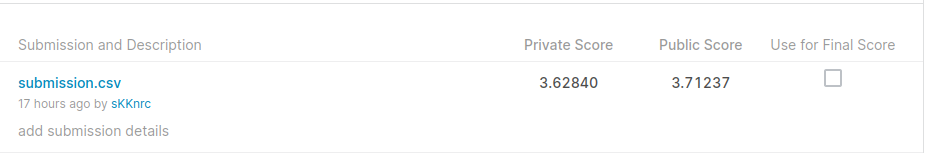